In [1]:
import pandas as pd
import numpy as np 
from bs4 import BeautifulSoup
from urllib.request import urlopen,Request
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import datetime as dt
import time
import nltk
import matplotlib.pyplot as plt
nltk.download('vader_lexicon')
vader= SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
print(vader.polarity_scores('i think that hamid is bad guy, but his results is poor'))
print(vader.polarity_scores('i think that hamid is good guy, but his results is poor'))
print(vader.polarity_scores('i think that hamid is good guy, and his results is satisfied us'))

{'neg': 0.416, 'neu': 0.584, 'pos': 0.0, 'compound': -0.7506}
{'neg': 0.275, 'neu': 0.596, 'pos': 0.129, 'compound': -0.4939}
{'neg': 0.0, 'neu': 0.637, 'pos': 0.363, 'compound': 0.6908}


In [3]:
us100=pd.read_html('https://en.wikipedia.org/wiki/Nasdaq-100')[4]
us100['Ticker']=us100['Ticker'].str.replace('.','-')
tickers=us100['Ticker'].unique().tolist()

C:\Users\USER\AppData\Local\Temp\ipykernel_4300\692791618.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  us100['Ticker']=us100['Ticker'].str.replace('.','-')


In [4]:
finviz_url = 'https://finviz.com/quote.ashx?t='
tickers 
news_tables = {}

for ticker in tickers:
    url = finviz_url + ticker

    req = Request(url=url, headers={'user-agent': 'my-app'})
    response = urlopen(req)

    html = BeautifulSoup(response, features='html.parser')
    news_table = html.find(id='news-table')
    news_tables[ticker] = news_table

parsed_data = []

for ticker, news_table in news_tables.items():
    if news_table:
        for row in news_table.findAll('tr'):
            title_tag = row.find('a', class_='tab-link-news')

            if title_tag:
                title = title_tag.text.strip()

                date_time_data = row.td.text.strip().split(' ')
                if len(date_time_data) == 1:
                    time = date_time_data[0]
                    date = ''  
                else:
                    date = date_time_data[0]
                    time = date_time_data[1]

                parsed_data.append([ticker, date, time, title])


In [5]:
df=pd.DataFrame(parsed_data,columns=['ticker', 'date', 'time', 'title'])
df['compound']=df['title'].apply(lambda x: vader.polarity_scores(x)['compound'])
#df['neg']=df['title'].apply(lambda x: vader.polarity_scores(x)['neg'])
#df['neu']=df['title'].apply(lambda x: vader.polarity_scores(x)['neu'])
#df['pos']=df['title'].apply(lambda x: vader.polarity_scores(x)['pos'])
df

,ticker,date,time,title,compound
0,ADBE,Jan-22-24,10:33AM,Ken Griffins Wellington Fund Delivers Mind-Num...,0.2023
1,ADBE,,09:30AM,Earnings Growth & Price Strength Make Adobe Sy...,0.7003
2,ADBE,,07:30AM,"AI Stocks: Tech Giants, Cloud Titans, Chipmake...",-0.3818
3,ADBE,,03:05AM,Design Software Stocks Q3 Highlights: Unity (N...,0.0000
4,ADBE,Jan-20-24,08:54PM,Canva Holders Are Said to Near Expanded $1.5 B...,0.2960
...,...,...,...,...,...
10091,ZS,,04:45PM,Zscaler Inc (ZS) Posts Robust Revenue Growth a...,0.8481
10092,ZS,,04:17PM,Zscaler: Fiscal Q1 Earnings Snapshot,0.0000
10093,ZS,,04:10PM,Zscaler (NASDAQ:ZS) Posts Better-Than-Expected...,0.0000
10094,ZS,,04:05PM,Zscaler Reports First Quarter Fiscal 2024 Fina...,0.0000


In [6]:
def convert(value):
    if value=='Today':
        return dt.datetime.today().strftime('%d-%m-%Y')
    return value
df['date']=df['date'].apply(convert)
df['date']=pd.to_datetime(df['date'])

C:\Users\USER\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '23-01-2024' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)


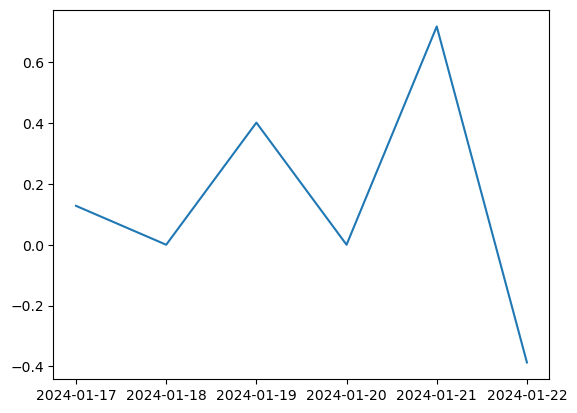

In [7]:
mean_df=df.groupby(['ticker','date']).mean()
mean_df=mean_df.reset_index()
mean_df[mean_df['date']==dt.datetime.today().strftime('%Y-%m-%d')]
app=mean_df[mean_df['ticker']=='MSFT']
plt.plot(app['date'],app['compound'])
plt.show()

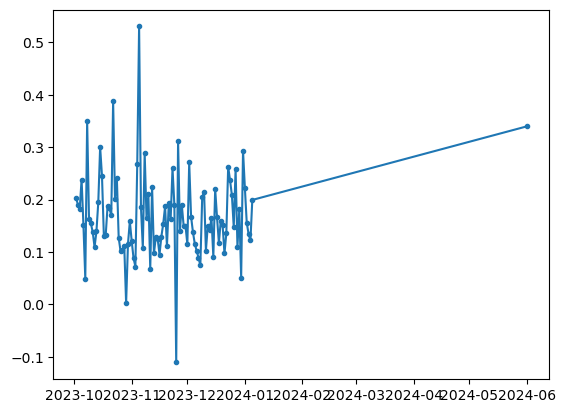

          date  compound
344 2023-10-02  0.203621
345 2023-10-03  0.190519
346 2023-10-04  0.182663
347 2023-10-05  0.238245
348 2023-10-06  0.150855
..         ...       ...
436 2024-01-02  0.155861
437 2024-01-03  0.134126
438 2024-01-04  0.122289
439 2024-01-05  0.199238
440 2024-06-01  0.339742

[97 rows x 2 columns]


In [19]:
daily_mean=df.groupby('date').mean().reset_index()
daily_mean=daily_mean[daily_mean['date']>'2023-10-01']
plt.plot(daily_mean['date'],daily_mean['compound'],marker='.')
plt.show()
print(daily_mean)

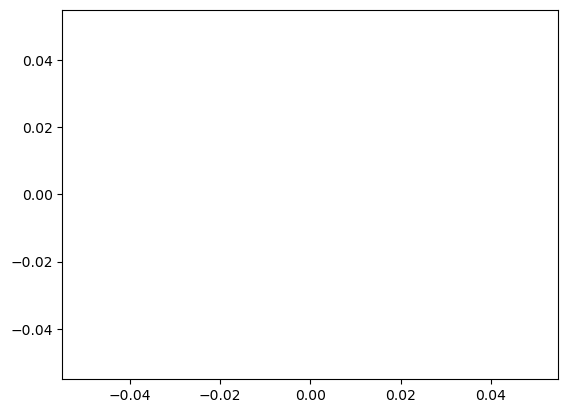

In [20]:
intraday=df[df['date']==dt.datetime.today().strftime('%Y-%m-%d')][['time','compound']]
intraday=pd.DataFrame(intraday)
intraday=intraday.sort_values(by='time')
plt.plot(intraday['time'],intraday['compound'],marker='.')

In [21]:
df.groupby('date').mean().reset_index().to_excel('sentiment.xlsx')